# Manually Adding Pores and Throats Using Extend

In [1]:
import openpnm as op
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(10)
ws = op.Workspace()
ws.settings['loglevel'] = 50

We'll start with something simple, by adding a single pore and throat to a 2D network:

In [2]:
pn = op.network.Cubic(shape=[5, 5, 1], spacing=1.0)

## Add a Single Pore

First add a pore and visualize it:

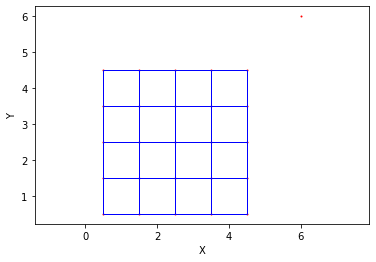

In [3]:
op.topotools.extend(network=pn, pore_coords=[[6, 6, 0.5]])
fig = op.topotools.plot_coordinates(network=pn)
fig = op.topotools.plot_connections(network=pn, fig=fig)

Note that we've only added a pore, but not specified any connections to other pores.  This requires quite a bit more thought than adding pore coords.  The original network had 25 pores, number 0 to 24 (due to python's 0 indexing), so this new pore is number 25.  Specifying connections requires explicitly stating which pores are connected to which according to the pore index.  

# Add a Single Throat
Let's connect this new pore to a the single pore in the top-left corner, which we know to be pore 4.  Again we'll use ``extend`` but specify ``throat_conns`` instead:

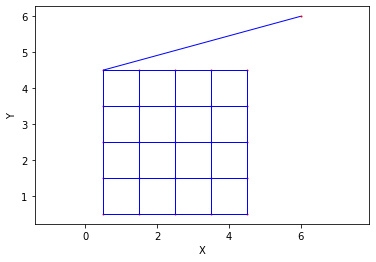

In [4]:
op.topotools.extend(network=pn, throat_conns=[[4, 25]])
fig = op.topotools.plot_coordinates(network=pn)
fig = op.topotools.plot_connections(network=pn, fig=fig)

## Find Several Throat and Add Simultaneously

We can also find the indices of pores that are physicall close to pore 25 , then make connections between those:

In [5]:
Ps = pn.find_nearby_pores(pores=25, r=3)
print(Ps)

[array([19, 23, 24])]


The above search yeilded 3 pores that are withing a radius of 3 units of pore 25.  In order to connected these to pore 25  y a new throat, we need to create a pair of indices indicating the pore on each the new throat as shown below.  This convention for defining network topology is based on the sparse adjacency matrix expressed in COO format, as described [here](.../tutorials/data_and_topology_storage.ipynb).

In [6]:
[[25, i] for i in Ps[0]]

[[25, 19], [25, 23], [25, 24]]

We can send this list to the ``extend`` function to add all three new throats with one call:

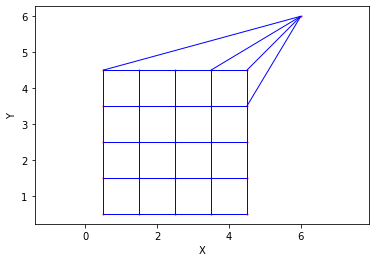

In [7]:
op.topotools.extend(network=pn, throat_conns=[[25, i] for i in Ps[0]])
fig = op.topotools.plot_coordinates(network=pn)
fig = op.topotools.plot_connections(network=pn, fig=fig)

## More Complex Additions

Now let's do something more complex, by adding pores inside a for-loop.  First create a simple 2D cubic network:

In [8]:
net = op.network.Cubic(shape=[5, 5, 1], spacing=1.0)

We'll now scan through each pores in the network and add 4 new pores next to each one, at the 4 corners:

In [9]:
Ps = net.Ps
Ts = net.Ts
coords = net['pore.coords']
dist = 0.3
corners = [[-1, -1], [-1, 1], [1, 1], [1, -1]]
for xdir, ydir in corners:
    adj = np.zeros_like(coords)
    adj[:, 0] = dist*xdir
    adj[:, 1] = dist*ydir
    new_coords = coords + adj
    op.topotools.extend(network=net, pore_coords=new_coords)
    new_Ps = net.Ps[-len(Ps):]
    new_conns = np.vstack((Ps, new_Ps)).T
    op.topotools.extend(network=net, throat_conns=new_conns)

After any network manipulation operation, it's a good idea to check the health of the network, which checks for disconnected pores.  All empty lists means nothing was found.

In [10]:
net.check_network_health()

{'disconnected_clusters': [], 'isolated_pores': [], 'trim_pores': [], 'duplicate_throats': [], 'bidirectional_throats': [], 'headless_throats': [], 'looped_throats': []}

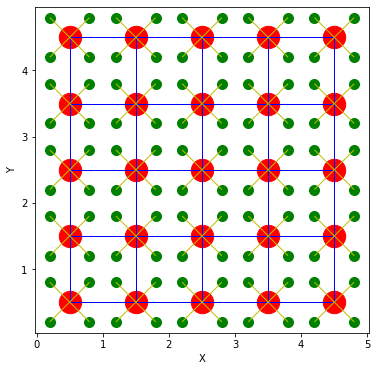

In [11]:
#NBVAL_IGNORE_OUTPUT
fig, ax = plt.subplots(1, figsize=[6, 6])
fig = op.topotools.plot_connections(network=net, throats=Ts, fig=fig, c='b')
fig = op.topotools.plot_connections(network=net, throats=net.Ts[len(Ts):], fig=fig, c='y')
fig = op.topotools.plot_coordinates(network=net, pores=Ps, c='r', s=500, fig=fig)
fig = op.topotools.plot_coordinates(network=net, pores=net.Ps[len(Ps):], c='g', s=100, fig=fig)
plt.show()